__Author:__ Bram Van de Sande

__Date:__ 27 FEB 2018

__Outline:__ Compare the results of the different implementation of the SCENIC pipeline. The example used in the tutorial is used in this comparison (https://github.com/aertslab/SCENIC). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyscenic.utils import save_to_yaml
%matplotlib inline

### Phase Ib: Derive potential regulomes from these co-expression modules

#### Check implementation of `modules_from_genie3`

Start from the GENIE3 output and check if derived co-expression modules are similar.

In [2]:
adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.5_GENIE3_linkList.txt',
                          usecols=['TF', 'Target', 'weight'])
adjacencies.columns = ["TF", "target", "importance"]

Creation of the modules.

In [3]:
df_modules = adjacencies[adjacencies['importance'] > 0.001]
df_modules['method'] = 'w001'

df_tmp = adjacencies[adjacencies['importance'] > 0.005].copy()
df_tmp['method'] = 'w005'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='TF').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(5, "importance")).copy()
df_tmp['method'] = 'top5perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(10, "importance")).copy()
df_tmp['method'] = 'top10perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50perTarget'
df_modules = df_modules.append(df_tmp)
df_modules.index = range(len(df_modules))

In [4]:
len(df_modules)

4363616

In [5]:
df_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

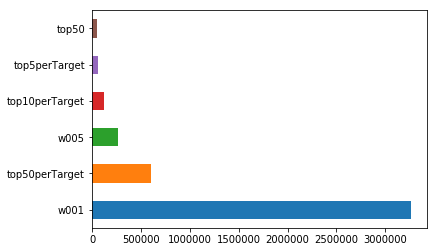

In [6]:
df_modules.method.value_counts().plot.barh()

In [7]:
df_modules[df_modules['TF'] == df_modules['target']]

,TF,target,importance,method


Compare the results with the modules derived by the R pipeline.

In [8]:
r_modules = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.6_tfModules.txt',
                          usecols=['Target', 'TF', 'method'])
r_modules.columns = ['target', 'TF', 'method']

In [9]:
len(r_modules)

4363616

In [10]:
r_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

Exact comparison.

In [11]:
COLUMN_NAMES = ['TF', 'target', 'method']
df_modules = df_modules[COLUMN_NAMES].sort_values(by=COLUMN_NAMES).reset_index()
del df_modules['index']

In [12]:
r_modules = r_modules.sort_values(by=COLUMN_NAMES).reset_index()
del r_modules['index']
r_modules = r_modules[COLUMN_NAMES]

In [13]:
r_modules.equals(df_modules)

True

### Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)

Testing of RcisTarget should start from exactly the same baseline. Modules for the python pipeline will therefore be created from the link lists with correlation information used in the R scripts.

In [16]:
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
import os
from collections import defaultdict
from pyscenic.genesig import Regulome
from operator import concat
from functools import reduce
from pyscenic.regulome import prune_targets

In [17]:
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"
DATABASE_FNAME_500bp = os.path.join(DATABASE_FOLDER, "mm9-500bp-upstream-10species.mc8nr.feather")
DATABASE_FNAME_10kbp = os.path.join(DATABASE_FOLDER, "mm9-tss-centered-10kb-10species.mc8nr.feather")

RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")

#### Create modules from R datafile

In [18]:
r_adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.7_tfModules_withCorr.txt',
                         usecols=['Target', 'TF', 'method', 'corr'])
r_adjacencies.head()

,Target,TF,method,corr
0,Slc27a3,1810024B03Rik,w001,0
1,Ankrd39,1810024B03Rik,w001,1
2,Tbc1d25,1810024B03Rik,w001,0
3,Mak,1810024B03Rik,w001,1
4,Tmem86b,1810024B03Rik,w001,1


1. Remove genes in a module that are not part of the database rankings.
2. Remove modules with number of genes < 20.
3. Add own TF to its own module.
4. Only look at TF-target that have an activiting function.

In [19]:
genes_in_db = RankingDatabase(DATABASE_FNAME_500bp, name="500bp", nomenclature="MGI").geneset
r_adjacencies = r_adjacencies[r_adjacencies['corr'] > 0]
method2modules = defaultdict(list)
for (tf, method), df_grp in r_adjacencies.groupby(by=['TF', 'method']):
    targets = set(df_grp['Target'].values)
    if len(targets) < 20:
        continue
    targets.add(tf)
    regulome = Regulome(name="{} - {}".format(tf, method), nomenclature="MGI", 
                        score=0.0, context=frozenset([method]),
                        transcription_factor=tf, gene2weights=targets.intersection(genes_in_db))
    method2modules[method].append(regulome)

In [20]:
for method, modules in method2modules.items():
    print(method, "-", len(modules))

top50 - 974
top50perTarget - 976
w001 - 1004
w005 - 612
top10perTarget - 486
top5perTarget - 259


In [21]:
modules = reduce(concat, method2modules.values())
len(modules)

4311

In [22]:
save_to_yaml(modules, os.path.join(RESOURCES_FOLDER, "modules_zeisel_2015.yaml"))

#### Create dataframe with enriched and TF-annotated motifs + leading edges

In [117]:
rnkdbs = [RankingDatabase(fname, name, "MGI") for fname, name in zip([DATABASE_FNAME_500bp, DATABASE_FNAME_10kbp], ['500bp', '10kbp'])]
rnkdbs

[FeatherRankingDatabase(name="500bp",nomenclature=MGI),
 FeatherRankingDatabase(name="10kbp",nomenclature=MGI)]

In [119]:
rnkdbs[0].load_full().shape

(20003, 22058)

In [120]:
from pyscenic.rnkdb import SQLiteRankingDatabase

In [122]:
sqldb = SQLiteRankingDatabase(os.path.join(DATABASE_FOLDER, "mm9-500bp-upstream-10species.mc8nr.db"), '500bp', 'MGI')

In [123]:
sqldb.load_full().shape

(20003, 22058)

In [10]:
df = derive_regulomes(rnkdbs, modules, 
                      MOTIF_ANNOTATIONS_FNAME, 
                      rank_threshold=5000, auc_threshold=0.01, nes_threshold=3.0,
                      output="df",
                      client_or_address="custom_multiprocessing", num_workers=6)

Using 6 workers.
2018-02-11 16:56:54.398657 - Worker 500bp(2): database loaded in memory.
2018-02-11 16:56:54.409113 - Worker 500bp(3): database loaded in memory.
2018-02-11 16:56:54.409830 - Worker 500bp(1): database loaded in memory.
2018-02-11 16:56:55.583456 - Worker 500bp(1): motif annotations loaded in memory.
2018-02-11 16:56:55.588399 - Worker 500bp(3): motif annotations loaded in memory.
2018-02-11 16:56:55.588453 - Worker 500bp(2): motif annotations loaded in memory.
2018-02-11 16:57:03.008167 - Worker 10kbp(3): database loaded in memory.
2018-02-11 16:57:03.032114 - Worker 10kbp(2): database loaded in memory.
2018-02-11 16:57:03.032861 - Worker 10kbp(1): database loaded in memory.
2018-02-11 16:57:04.672461 - Worker 10kbp(3): motif annotations loaded in memory.
2018-02-11 16:57:04.692973 - Worker 10kbp(2): motif annotations loaded in memory.
2018-02-11 16:57:04.701290 - Worker 10kbp(1): motif annotations loaded in memory.
2018-02-11 18:50:07.444854 - Worker 500bp(3): All reg

__Potential causes of differences:__
1. _0-based rankings (python) versus 1-based rankings (R SCENIC version)?_ This has an effect on the interpretation of rank_cutoff. With 0-based the rank_cutoff is included while in 1-based systems this is not the cause. Both are correct calculations but just a difference in interpretation of the parameter. The normalization factor (maxAUC) should be corrected though.
```
aucThreshold <- round(aucMaxRank)
maxAUC <- aucThreshold * nrow(gSetRanks)
```
(According to this code snippet the maxAUC is calculated to take the aucThreshold into account while this is not the case for the current R implementation of the AUC calculation + 1-based rankings)
```
.auc <- function(oneRanking, aucThreshold, maxAUC)
{
  x <- oneRanking
  x <- sort(x[x<aucThreshold])

  y <- seq_along(x)
  sum(diff(c(x, aucThreshold)) * y)/maxAUC
}
```
2. _NES threshold (3.0)_. Exactly the same for both pipeline.
3. _Digits for truncation of NES and AUC values (3)_. Is available in the R version of the pipeline. This should have no effect on the calculations as this is only used for creating the final results table.
4. _Rank threshold (5000)_. Is exactly the same. Can only have an effect on the LE calculation. Has no effect on AUC calculations.
5. _AUC fraction (0.01)_. Is used to calculate the rank cutoff. Is the same between both pipelines. However the way the AUC cutoff is calculated in the R implementation was different because it is never rounded (which was the case in the python version). This difference was corrected by using a ceil operation in python (=using float in less than comparison operation).
6. _Minimum orthologous identity and maximum motif similarity FDR_: effect can be assessed in the results table from the python pipeline. But currently the R-based pipeline differentiates only two levels: directly annotated (direct or through orthologous identity) + inferred annotations through motif similarity.
7. _Ranking databases (500bp-upstream and 10kp-centered-arount-tss; both 20k features, i.e. version 8)_. Should be the same.
__But:__ 20,003 in python (feather) while according to documentation for R version there should be 20,004 features (https://htmlpreview.github.io/?https://github.com/aertslab/SCENIC/blob/master/inst/doc/Step2_Regulons.html).
8. _Some gene signatures are removed before NES calculation_: If more than 80% of genes of a signatures are missing. This signature is skipped. This should not affect the AUC calculation at all because AUC is calculated across features for the same signature only. This is now also part of the pySCENIC implementation.

```
if(all(missingPercent>=.80))
    stop("Fewer than 20% of the genes in the gene sets",
         " are included in the rankings.",
         "Check wether the gene IDs in the 'rankings' and 'geneSets' match.")

  if(any(missingPercent>.80))
  {
    warning("The following gene sets will be excluded from the analysis",
            "(less than 20% of their genes are available):\n",
            paste(names(missingPercent)[which(missingPercent >= .80)],
                  collapse=", "),
            immediate.=TRUE)
    aucMatrix <- aucMatrix[which(missingPercent < .80),,drop=FALSE]
  }
```

In [11]:
len(df)

13527

In [12]:
df.head()

Enrichment            \
                                            AUC       NES   
TF     MotifID                                              
Acaa1b transfac_pro__M01543            0.076742  4.867355   
       transfac_pro__M04671            0.076380  4.841798   
Ar     homer__CCAGGAACAG_AR-halfsite   0.050721  7.579484   
Arid3a transfac_pro__M04727            0.033484  3.125181   
       cisbp__M4455                    0.035068  3.301812   

                                                            \
                                     MotifSimilarityQvalue   
TF     MotifID                                               
Acaa1b transfac_pro__M01543                       0.000000   
       transfac_pro__M04671                       0.000000   
Ar     homer__CCAGGAACAG_AR-halfsite              0.000000   
Arid3a transfac_pro__M04727                       0.000255   
       cisbp__M4455                               0.000009   

                                                          \
                                     OrthologousIdentity   
TF     MotifID                                             
Acaa1b transfac_pro__M01543                     0.517986   
       transfac_pro__M04671                     0.517986   
Ar     homer__CCAGGAACAG_AR-halfsite            0.877642   
Arid3a transfac_pro__M04727                     0.798669   
       cisbp__M4455                             0.798669   

                                                                                         \
                                                                             Annotation   
TF     MotifID                                                                            
Acaa1b transfac_pro__M01543           motif similar to transfac_pro__M04671 ('F$POT1...   
       transfac_pro__M04671           motif is annotated for orthologous gene YIL160...   
Ar     homer__CCAGGAACAG_AR-halfsite  gene is orthologous to ENSG00000169083 in H. s...   
Arid3a transfac_pro__M04727           gene is orthologous to ENSG00000116017 in H. s...   
       cisbp__M4455                   gene is orthologous to ENSG00000116017 in H. s...   

                                                      \
                                             Context   
TF     MotifID                                         
Acaa1b transfac_pro__M01543           (top50, 500bp)   
       transfac_pro__M04671           (top50, 500bp)   
Ar     homer__CCAGGAACAG_AR-halfsite  (top50, 500bp)   
Arid3a transfac_pro__M04727           (top50, 500bp)   
       cisbp__M4455                   (top50, 500bp)   

                                                                                         
                                                                            TargetGenes  
TF     MotifID                                                                           
Acaa1b transfac_pro__M01543           [(Col7a1, 1.0), (Lmna, 1.0), (Crh, 1.0), (Htr1...  
       transfac_pro__M04671           [(Col7a1, 1.0), (Lmna, 1.0), (Crh, 1.0), (Htr1...  
Ar     homer__CCAGGAACAG_AR-halfsite        [(Bmpr1b, 1.0), (Kcns1, 1.0), (Ptpru, 1.0)]  
Arid3a transfac_pro__M04727                                               [(Sdk2, 1.0)]  
       cisbp__M4455                                    [(Hbegf, 1.0), (Tnfaip8l2, 1.0)]

There are far less regulomes when using the python pipeline.

In [13]:
df.index.get_level_values('TF').unique()

Index(['Acaa1b', 'Ar', 'Arid3a', 'Arid5b', 'Arx', 'Ascl1', 'Atf1', 'Atf2',
       'Atf3', 'Atf4',
       ...
       'Sox12', 'Tia1', 'Zfp148', 'Gli3', 'Grhl1', 'Meis2', 'Olig2', 'Zfhx2',
       'Zfp672', 'Zfp467'],
      dtype='object', name='TF', length=399)

In [14]:
df.index.get_level_values('TF').unique().values

array(['Acaa1b', 'Ar', 'Arid3a', 'Arid5b', 'Arx', 'Ascl1', 'Atf1', 'Atf2',
       'Atf3', 'Atf4', 'Atf5', 'Atf6', 'Bbx', 'Bhlhe22', 'Cbfb', 'Ccnt2',
       'Cebpb', 'Cebpg', 'Cic', 'Ckmt1', 'Clock', 'Cpsf4', 'Creb1',
       'Creb3', 'Creb3l1', 'Crebl2', 'Ctcf', 'Dbx2', 'Dlx1', 'Dlx2',
       'Dlx5', 'Dmrta2', 'E2f1', 'E2f3', 'E2f4', 'E2f5', 'E2f6', 'E4f1',
       'Egr4', 'Elf1', 'Elk3', 'Elk4', 'Emx1', 'Ep300', 'Ets1', 'Ets2',
       'Etv3', 'Etv4', 'Fli1', 'Fos', 'Fosb', 'Fosl2', 'Foxj3', 'Foxk1',
       'Foxo1', 'Foxp1', 'Foxp2', 'Gabpb1', 'Gata2', 'Gtf2b', 'Hif1a',
       'Hivep3', 'Homez', 'Hsf1', 'Irf2', 'Irf3', 'Irf9', 'Jdp2', 'Jun',
       'Junb', 'Jund', 'Kdm5a', 'Klf16', 'Klf2', 'Lhx6', 'Maf', 'Mef2a',
       'Mxd4', 'Myc', 'Neurod1', 'Nfe2l1', 'Nfe2l2', 'Nfib', 'Nfic',
       'Nkx2-2', 'Nr1d1', 'Nr1d2', 'Nr2c1', 'Nr2e1', 'Nr2f1', 'Nr2f2',
       'Nr2f6', 'Nr3c1', 'Nr6a1', 'Patz1', 'Pbx3', 'Pbx4', 'Pck2', 'Phf8',
       'Pole3', 'Polr3g', 'Pou2f1', 'Pou3f2', 'Pou3f4', 'Ppard',

Compare the top 5 results documented in the tutorial.

In [15]:
df[df.index.get_level_values('TF') == 'Rfx3'].sort_values(by=('Enrichment', 'NES'), ascending=False)

Enrichment            \
                                                    AUC       NES   
TF   MotifID                                                        
Rfx3 cisbp__M1524                              0.100987  9.658617   
     cisbp__M1533                              0.092349  8.776800   
     cisbp__M1539                              0.092349  8.776800   
     cisbp__M1528                              0.090498  8.587839   
     cisbp__M1524                              0.113414  8.382514   
     cisbp__M1525                              0.088235  8.356887   
     cisbp__M1529                              0.085253  8.052451   
     cisbp__M1537                              0.097796  7.833938   
     cisbp__M1536                              0.082991  7.821499   
     cisbp__M1537                              0.082991  7.821499   
     cisbp__M1524                              0.095898  7.671349   
     cisbp__M1529                              0.095752  7.658842   
     cisbp__M1533                              0.101445  7.434598   
     cisbp__M1539                              0.101445  7.434598   
     cisbp__M1535                              0.092687  7.396198   
     cisbp__M1528                              0.098672  7.214959   
     cisbp__M1534                              0.076923  7.202127   
     cisbp__M1530                              0.090060  7.171075   
     yetfasco__YLR176C_496                     0.076512  7.160136   
     cisbp__M1525                              0.095606  6.972200   
     cisbp__M1537                              0.068902  6.953047   
     hdpi__RFX3                                0.073632  6.866197   
     transfac_pro__M02789                      0.073221  6.824206   
     cisbp__M1524                              0.067565  6.806619   
     cisbp__M1528                              0.085681  6.795869   
     cisbp__M1539                              0.085681  6.795869   
     cisbp__M1529                              0.067462  6.795355   
     cisbp__M1534                              0.014646  6.786273   
     cisbp__M1532                              0.085535  6.783362   
     cisbp__M1524                              0.076237  6.738998   
...                                                 ...       ...   
     cisbp__M1528                              0.019666  3.243580   
     cisbp__M2309                              0.034862  3.224760   
     transfac_pro__M07305                      0.011548  3.206031   
     cisbp__M1530                              0.017287  3.196852   
     cisbp__M1524                              0.017287  3.196852   
     transfac_pro__M07123                      0.039079  3.190720   
     scertf__macisaac.RFX1                     0.038941  3.177626   
     cisbp__M1539                              0.019337  3.165574   
     cisbp__M2309                              0.038804  3.164533   
     cisbp__M5780                              0.038804  3.164533   
     cisbp__M5775                              0.038667  3.151440   
     cisbp__M6451                              0.017113  3.150325   
     cisbp__M6077                              0.047292  3.145857   
     cisbp__M1529                              0.017017  3.124477   
     transfac_pro__M07882                      0.011416  3.123059   
     cisbp__M6451                              0.047000  3.122737   
     cisbp__M4575                              0.010186  3.119443   
     taipale__RFX2_DBD_NGTTRCCATGGYAACN_repr   0.038256  3.112160   
     cisbp__M6452                              0.010164  3.101402   
     cisbp__M1535                              0.037982  3.085973   
     yetfasco__YLR176C_496                     0.034828  3.082748   
     cisbp__M1525                              0.016804  3.067611   
     transfac_pro__M04759                      0.011327  3.066592   
     transfac_pro__M04759                      0.046271  3.064937   
     transfac_pro__M07880                  

Save to disk.

In [16]:
df.to_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"))

In [69]:
df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
                 index_col=[0,1], header=[0,1], skipinitialspace=True)
len(df)

22013

Compare enriched motifs with results from R pipeline.

In [61]:
r_df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "rscenic/2.4_motifEnrichment_selfMotifs.txt"))

In [62]:
r_df.sort_values(by='NES', ascending=False).sort_values(by=['highlightedTFs']).head(15)

,Unnamed: 0,motifDb,geneSet,motif,NES,AUC,highlightedTFs,TFinDB,TF_direct,TF_inferred
1,2,500bp,Acaa1b_top50,transfac_pro__M04671,4.28,0.0733,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
0,1,500bp,Acaa1b_top50,transfac_pro__M01543,4.39,0.0749,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
2,3,500bp,Ahr_w001,transfac_pro__M00778,3.22,0.0131,Ahr,**,Ahr,NaN
4,5,500bp,Ahr_w001,cisbp__M6139,3.08,0.0128,Ahr,**,Ahr,Arnt
5,6,500bp,Ahr_w001,transfac_pro__M00976,3.03,0.0127,Ahr,**,Ahr; Ahrr; Arnt; Arnt2; Hif1a,NaN
3,4,500bp,Ahr_w001,hocomoco__AHR_HUMAN.H10MO.B,3.12,0.0129,Ahr,**,Ahr,Arnt
6,7,500bp,Anxa11_top50,hdpi__ANXA11,3.15,0.0478,Anxa11,**,Anxa11,NaN
46,47,500bp,Ar_top50,homer__CCAGGAACAG_AR-halfsite,7.21,0.0537,Ar,**,Ar,NaN
5037,5038,10kbp,Ar_top50,cisbp__M5683,3.12,0.0322,Ar,**,Ar; Nr3c1; Nr3c2,NaN
5017,5018,10kbp,Arid3a_w001,tfdimers__MD00454,3.10,0.0151,Arid3a,**,Arid3a; Pax4,NaN


In [63]:
r_df = r_df.rename(columns={'motifDb': 'DbId', 'geneSet': 'ModuleType', 'motif': 'MotifID', 'highlightedTFs': 'TF'})

In [64]:
COLUMNS = ['DbId', 'ModuleType', 'MotifID', 'TF', 'AUC', 'NES']
r_df = r_df[COLUMNS]

In [65]:
r_df['ModuleType'] = r_df['ModuleType'].apply(lambda s: s.split("_")[1])

In [66]:
r_df.head()

,DbId,ModuleType,MotifID,TF,AUC,NES
0,500bp,top50,transfac_pro__M01543,Acaa1b,0.0749,4.39
1,500bp,top50,transfac_pro__M04671,Acaa1b,0.0733,4.28
2,500bp,w001,transfac_pro__M00778,Ahr,0.0131,3.22
3,500bp,w001,hocomoco__AHR_HUMAN.H10MO.B,Ahr,0.0129,3.12
4,500bp,w001,cisbp__M6139,Ahr,0.0128,3.08


In [70]:
df.sort_values(by=[('Enrichment', 'NES')], ascending=False).sort_index(level=0).head(20)

Enrichment            \
                                            AUC       NES   
TF     MotifID                                              
Abcf2  hdpi__ABCF2                     0.023643  2.691416   
       hdpi__ABCF2                     0.024249  2.546799   
       hdpi__ABCF2                     0.021493  2.514265   
Acaa1b transfac_pro__M01543            0.076018  4.853421   
       transfac_pro__M01543            0.060004  3.456986   
       transfac_pro__M01543            0.023736  2.842316   
       transfac_pro__M04671            0.075656  4.827692   
       transfac_pro__M04671            0.058824  3.378407   
       transfac_pro__M04671            0.023621  2.823518   
Ahr    cisbp__M6139                    0.013002  3.569795   
       transfac_pro__M00778            0.013922  4.018698   
       transfac_pro__M00976            0.012276  3.215661   
       transfac_pro__M07347            0.011218  2.699423   
       transfac_public__M00235         0.029250  2.789930   
Anxa11 hdpi__ANXA11                    0.043170  2.892094   
Ar     homer__CCAGGAACAG_AR-halfsite   0.050405  7.587771   
       transfac_pro__M00962            0.033452  2.693963   
       transfac_pro__M02014            0.039108  3.227379   
       transfac_pro__M02014            0.025466  2.546731   
       transfac_pro__M03827            0.068520  6.001144   

                                                            \
                                     MotifSimilarityQvalue   
TF     MotifID                                               
Abcf2  hdpi__ABCF2                                0.000000   
       hdpi__ABCF2                                0.000000   
       hdpi__ABCF2                                0.000000   
Acaa1b transfac_pro__M01543                       0.000000   
       transfac_pro__M01543                       0.000000   
       transfac_pro__M01543                       0.000000   
       transfac_pro__M04671                       0.000000   
       transfac_pro__M04671                       0.000000   
       transfac_pro__M04671                       0.000000   
Ahr    cisbp__M6139                               0.000000   
       transfac_pro__M00778                       0.000000   
       transfac_pro__M00976                       0.000000   
       transfac_pro__M07347                       0.000000   
       transfac_public__M00235                    0.000000   
Anxa11 hdpi__ANXA11                               0.000000   
Ar     homer__CCAGGAACAG_AR-halfsite              0.000000   
       transfac_pro__M00962                       0.000000   
       transfac_pro__M02014                       0.000029   
       transfac_pro__M02014                       0.000029   
       transfac_pro__M03827                       0.000093   

                                                          \
                                     OrthologousIdentity   
TF     MotifID                                             
Abcf2  hdpi__ABCF2                              0.982484   
       hdpi__ABCF2                              0.982484   
       hdpi__ABCF2                              0.982484   
Acaa1b transfac_pro__M01543                     0.517986   
       transfac_pro__M01543                     0.517986   
       transfac_pro__M01543                     0.517986   
       transfac_pro__M04671                     0.517986   
       transfac_pro__M04671                     0.517986   
       transfac_pro__M04671                     0.517986   
Ahr    cisbp__M6139                             0.732919   
       transfac_pro__M00778                     1.000000   
       transfac_pro__M00976                     1.000000   
       transfac_pro__M07347                     1.000000   
       transfac_public__M00235                  1.000000   
Anxa11 hdpi__ANXA11                             0.932406   
Ar     homer__CCAGGAACAG_AR-halfsite            0.877642   
       transfac_pro__M00962                     1.000000   
      

In [71]:
df.columns = df.columns.droplevel(0)

In [72]:
df = df.reset_index()

In [73]:
df.head()

,TF,MotifID,AUC,NES,MotifSimilarityQvalue,OrthologousIdentity,Annotation,Context,TargetGenes
0,Acaa1b,transfac_pro__M01543,0.076018,4.853421,0.000000,0.517986,motif similar to transfac_pro__M04671 ('F$POT1...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Col7a1', 1.0), ('Lmna', 1.0), ('Crh', 1.0),..."
1,Acaa1b,transfac_pro__M04671,0.075656,4.827692,0.000000,0.517986,motif is annotated for orthologous gene YIL160...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Col7a1', 1.0), ('Lmna', 1.0), ('Crh', 1.0),..."
2,Anxa11,hdpi__ANXA11,0.043170,2.892094,0.000000,0.932406,gene is orthologous to ENSG00000122359 in H. s...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Ksr2', 1.0)]"
3,Ar,homer__CCAGGAACAG_AR-halfsite,0.050405,7.587771,0.000000,0.877642,gene is orthologous to ENSG00000169083 in H. s...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Bmpr1b', 1.0), ('Kcns1', 1.0), ('Ptpru', 1.0)]"
4,Arid3a,transfac_pro__M04727,0.033258,3.127699,0.000255,0.798669,gene is orthologous to ENSG00000116017 in H. s...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Sdk2', 1.0)]"


In [85]:
DB_MAP = {
    'mm9-500bp-upstream-10species': '500bp',
    'mm9-tss-centered-10kb-10species': '10kbp'
}
df['DbId'] = df['Context'].apply(lambda s: DB_MAP[next(iter(eval(s)))])
def get2nd(s):
    i = iter(eval(s))
    next(i)
    return next(i)
df['ModuleType'] = df['Context'].apply(lambda s: get2nd(s))

In [86]:
df.DbId.unique()

array(['500bp', '10kbp'], dtype=object)

In [87]:
df.ModuleType.unique()

array(['top50', 'top50perTarget', 'w001', 'w005', 'top10perTarget',
       'top5perTarget'], dtype=object)

In [88]:
df.head()

,TF,MotifID,AUC,NES,MotifSimilarityQvalue,OrthologousIdentity,Annotation,Context,TargetGenes,DbId,ModuleType
0,Acaa1b,transfac_pro__M01543,0.076018,4.853421,0.000000,0.517986,motif similar to transfac_pro__M04671 ('F$POT1...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Col7a1', 1.0), ('Lmna', 1.0), ('Crh', 1.0),...",500bp,top50
1,Acaa1b,transfac_pro__M04671,0.075656,4.827692,0.000000,0.517986,motif is annotated for orthologous gene YIL160...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Col7a1', 1.0), ('Lmna', 1.0), ('Crh', 1.0),...",500bp,top50
2,Anxa11,hdpi__ANXA11,0.043170,2.892094,0.000000,0.932406,gene is orthologous to ENSG00000122359 in H. s...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Ksr2', 1.0)]",500bp,top50
3,Ar,homer__CCAGGAACAG_AR-halfsite,0.050405,7.587771,0.000000,0.877642,gene is orthologous to ENSG00000169083 in H. s...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Bmpr1b', 1.0), ('Kcns1', 1.0), ('Ptpru', 1.0)]",500bp,top50
4,Arid3a,transfac_pro__M04727,0.033258,3.127699,0.000255,0.798669,gene is orthologous to ENSG00000116017 in H. s...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Sdk2', 1.0)]",500bp,top50


In [89]:
r_df.head()

,DbId,ModuleType,MotifID,TF,AUC,NES
0,500bp,top50,transfac_pro__M01543,Acaa1b,0.0749,4.39
1,500bp,top50,transfac_pro__M04671,Acaa1b,0.0733,4.28
2,500bp,w001,transfac_pro__M00778,Ahr,0.0131,3.22
3,500bp,w001,hocomoco__AHR_HUMAN.H10MO.B,Ahr,0.0129,3.12
4,500bp,w001,cisbp__M6139,Ahr,0.0128,3.08


In [90]:
r_df.DbId.unique()

array(['500bp', '10kbp'], dtype=object)

In [92]:
COMMON=['TF', 'MotifID', 'DbId', 'ModuleType']
c_df = pd.merge(r_df, df, left_on=COMMON, right_on=COMMON, suffixes=['_R', '_python'])

Comparison of AUC values in a scatter plot.

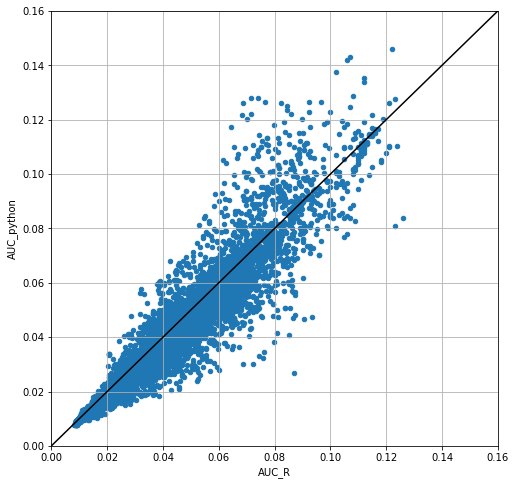

In [115]:
fig, ax = plt.subplots(figsize=(8,8))
c_df.plot.scatter(x='AUC_R', y='AUC_python', grid=True, ax=ax)
plt.xlim([0, 0.16])
plt.ylim([0, 0.16])
import matplotlib.pyplot as plt
plt.plot([0, 0.16], [0, 0.16], 'k-')

Comparison of NES values in a scatter plot.

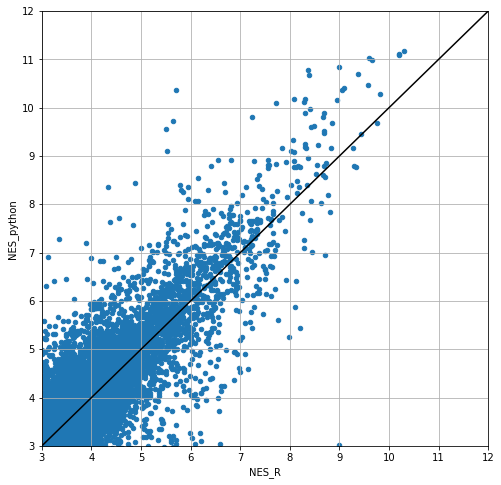

In [114]:
fig, ax = plt.subplots(figsize=(8,8))
c_df.plot.scatter(x='NES_R', y='NES_python', ax=ax, grid=True)
plt.xlim([3, 12])
plt.ylim([3, 12])
plt.plot([3, 12], [3, 12], 'k-')

#### Creation of regulomes

In [135]:
from pyscenic.regulome import df2regulomes

In [231]:
pydf = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
                 index_col=[0,1], header=[0,1], skipinitialspace=True)

In [234]:
pydf[('Enrichment', 'TargetGenes')] = list(map(eval, pydf[('Enrichment', 'TargetGenes')]))

In [235]:
regulomes = df2regulomes(pydf, "MGI")

In [236]:
len(regulomes)

504

In [237]:
regulomes[0:3]

[Regulome(name='Abcf2', nomenclature='MGI', gene2weights=<frozendict {'Morc2b': 1.0}>, transcription_factor='Abcf2', context=frozenset(), score=2.64427319918385),
 Regulome(name='Acaa1b', nomenclature='MGI', gene2weights=<frozendict {'Col7a1': 1.0, 'Lmna': 1.0, 'Crh': 1.0, 'Htr1f': 1.0, 'Foxp2': 1.0, 'Rilpl2': 1.0, 'Phf21b': 1.0, 'Poli': 1.0, 'Mtfr1': 1.0}>, transcription_factor='Acaa1b', context=frozenset(), score=2.514003893825529),
 Regulome(name='Ahr', nomenclature='MGI', gene2weights=<frozendict {'Crh': 1.0, 'Smad3': 1.0, 'Usp28': 1.0, 'Zbtb25': 1.0, 'Samd12': 1.0, 'Bhlhe41': 1.0, 'Maf': 1.0, 'Pou2f1': 1.0, 'St5': 1.0, 'Lin28b': 1.0, 'Maml3': 1.0, 'Zswim5': 1.0, 'Islr2': 1.0, 'Smoc2': 1.0, 'BC048403': 1.0, 'Slc25a36': 1.0, 'Erlin2': 1.0, 'Mir682': 1.0, 'Arrb2': 1.0, 'Aatf': 1.0, 'Apaf1': 1.0, 'Adrb2': 1.0, 'Dll3': 1.0, 'Kdm2b': 1.0, 'Tfdp2': 1.0, 'Nr4a2': 1.0, 'Phip': 1.0, 'Klf6': 1.0, 'Gjd2': 1.0, 'Dag1': 1.0, 'Igf2bp3': 1.0, '1190002N15Rik': 1.0, 'Gm129': 1.0, 'Kdm6a': 1.0, 'Slc

In [238]:
py_name2targets = { r.transcription_factor: set(list(r.genes)) for r in regulomes }

In [239]:
len(py_name2targets)

504

In [240]:
regulomes[0].genes

('Morc2b',)

In [241]:
py_name2targets['Abcf2']

{'Morc2b'}

To compare:
1. Plot venn diagrams on number of regulomes each and in common.
2. Heatmap with Jaccard Index for intersection.

In [140]:
r_incidences = pd.read_csv(os.path.join(RESOURCES_FOLDER, "rscenic/2.6_regulons_asIncidMat.txt"), index_col=0)

In [141]:
r_incidences.shape

(554, 11336)

In [142]:
from matplotlib_venn import venn2

In [165]:
r_extended = set(map(lambda n: n.split('_')[0], filter(lambda n: n.endswith('_extended'), r_incidences.index)))

In [166]:
r_not_extended = set(filter(lambda n: not n.endswith('_extended'), r_incidences.index))

In [167]:
len(r_extended)

236

In [168]:
len(r_not_extended)

318

In [169]:
len(r_extended.union(r_not_extended))

391

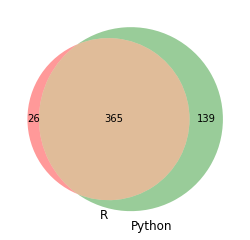

In [170]:
from operator import attrgetter
r_names = r_extended.union(r_not_extended)
py_names = set(map(attrgetter('name'), regulomes))
n_intersect = len(r_names.intersection(py_names))
venn2(subsets = (len(r_names)-n_intersect, len(py_names)-n_intersect, n_intersect), set_labels=('R', 'Python'))

In [272]:
r_name2targets = {tf.split('_')[0]:set(row.index[list(map(bool, row.values))].values)
                  for tf, (_, row) in zip(r_incidences.index, r_incidences.iterrows()) if not tf.endswith("_extended")}

In [273]:
tmp_name2targets = {tf.split('_')[0]:set(row.index[list(map(bool, row.values))].values)
                  for tf, (_, row) in zip(r_incidences.index, r_incidences.iterrows()) if tf.endswith("_extended")}

In [274]:
from cytoolz import merge_with

def union(args):
    if len(args) == 1:
        return args[0]
    return args[0].union(args[1])

r_name2targets_extended = merge_with(union, r_name2targets, tmp_name2targets)

Text(0.5,1,'Distribution of Jaccard Index')

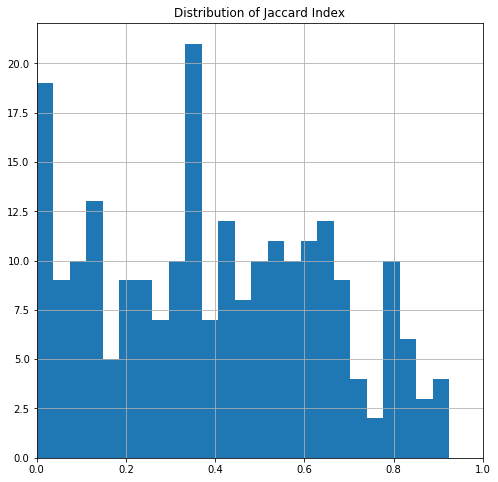

In [259]:
names = set(r_name2targets.keys()).intersection(set(py_name2targets))
n = len(names)
def jaccard(s1, s2):
    return float(len(s1.intersection(s2)))/len(s1.union(s2))
fig, ax = plt.subplots(figsize=(8,8))
pd.DataFrame(data=list(jaccard(r_name2targets[name], py_name2targets[name]) for name in names), index=names).hist(bins=25, ax=ax)
plt.xlim([0, 1.0])
plt.title('Distribution of Jaccard Index')

Text(0.5,1,'Distribution of Jaccard Index')

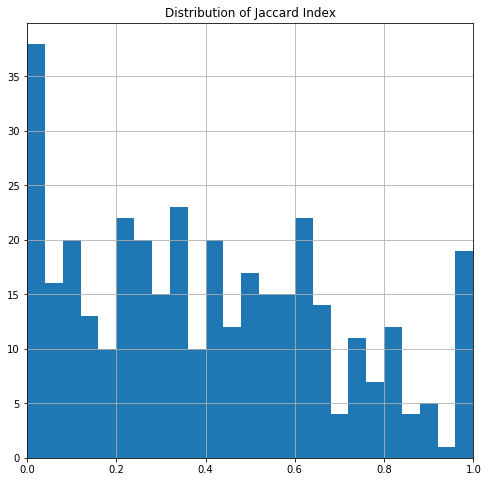

In [286]:
names = set(r_name2targets_extended.keys()).intersection(set(py_name2targets))
n = len(names)
def jaccard(s1, s2):
    return float(len(s1.intersection(s2)))/len(s1.union(s2))
fig, ax = plt.subplots(figsize=(8,8))
ji = pd.DataFrame(data=list(jaccard(r_name2targets_extended[name], py_name2targets[name]) for name in names), index=names)
ji.hist(bins=25, ax=ax)
plt.xlim([0, 1.0])
plt.title('Distribution of Jaccard Index')

__Potential explanation of differences in LE__:
1. The R implementation uses an approx method to calculate the avg + 2 std RCC.

 

In [276]:
c_df.head()

,DbId,ModuleType,MotifID,TF,AUC_R,NES_R,AUC_python,NES_python,MotifSimilarityQvalue,OrthologousIdentity,Annotation,Context,TargetGenes
0,500bp,top50,transfac_pro__M01543,Acaa1b,0.0749,4.39,0.076018,4.853421,0.0,0.517986,motif similar to transfac_pro__M04671 ('F$POT1...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Col7a1', 1.0), ('Lmna', 1.0), ('Crh', 1.0),..."
1,500bp,top50,transfac_pro__M04671,Acaa1b,0.0733,4.28,0.075656,4.827692,0.0,0.517986,motif is annotated for orthologous gene YIL160...,"frozenset({'top50', 'mm9-500bp-upstream-10spec...","[('Col7a1', 1.0), ('Lmna', 1.0), ('Crh', 1.0),..."
2,500bp,w001,transfac_pro__M00778,Ahr,0.0131,3.22,0.013922,4.018698,0.0,1.000000,gene is directly annotated,"frozenset({'mm9-500bp-upstream-10species', 'w0...","[('Smad3', 1.0), ('Maf', 1.0), ('Usp28', 1.0),..."
3,500bp,w001,cisbp__M6139,Ahr,0.0128,3.08,0.013002,3.569795,0.0,0.732919,gene is orthologous to ENSG00000106546 in H. s...,"frozenset({'mm9-500bp-upstream-10species', 'w0...","[('Crh', 1.0), ('Smad3', 1.0), ('Usp28', 1.0),..."
4,500bp,w001,transfac_pro__M00976,Ahr,0.0127,3.03,0.012276,3.215661,0.0,1.000000,gene is directly annotated,"frozenset({'mm9-500bp-upstream-10species', 'w0...","[('Zbtb25', 1.0), ('Gm129', 1.0), ('Bhlhe41', ..."


In [283]:
tf2nes = c_df[['TF', 'NES_python']].groupby(by='TF').mean()

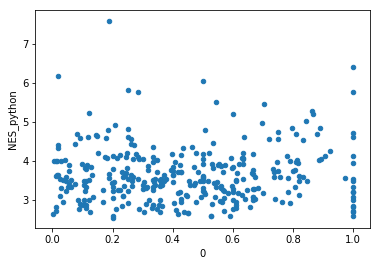

In [290]:
pd.merge(ji, tf2nes, left_index=True, right_index=True).plot.scatter(x=0, y='NES_python')